In [1]:
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import time
from datetime import timedelta
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GridSearchCV, learning_curve, train_test_split, validation_curve)
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
DATA_PATH = '../data/'

In [3]:
!../scripts/copy_data.sh
!ls -la ../data

total 3968
drwxr-xr-x  10 dsp  staff      340 Sep  3 12:21 .
drwxr-xr-x  11 dsp  staff      374 Sep 30  2017 ..
-rw-r--r--@  1 dsp  staff     6148 Mar 23  2018 .DS_Store
-rw-r--r--@  1 dsp  staff    64799 Sep 30  2017 Multistock.csv
drwxr-xr-x   4 dsp  staff      136 Oct 15 21:17 bak
-rw-r--r--   1 dsp  staff   318781 Oct 17 00:38 buyStats.csv
-rw-r--r--@  1 dsp  staff  1195307 Oct 16 19:50 sp1950.csv
-rw-r--r--@  1 dsp  staff   358037 Sep  3 12:22 ssec.csv
-rw-r--r--@  1 dsp  staff    15935 Oct 15 21:17 stocks.csv
-rw-r--r--   1 dsp  staff    62328 Sep 10 23:23 weights.bestNN.hdf5


In [4]:
def read(filepath, pred=False):
    dat = pd.read_csv(filepath)
    if not pred:
        dat['buyDate'] = pd.to_datetime(dat['buyDate'])
    return dat

In [5]:
dat = read(DATA_PATH + 'buyStats.csv')

In [6]:
def remove_commas(value):
    if type(value) == str:
        return float(value.replace(',', ''))
    else:
        return value

In [7]:
dat['freeCashFlow_'] = dat['freeCashFlow_'].apply(lambda x: remove_commas(x))
dat['mCap_'] = dat['mCap_'].apply(lambda x: remove_commas(x))

In [8]:
dat['industry'] = dat['industry'].apply(lambda x: str(x))
dat['sector']   = dat['sector'].apply(lambda x: str(x))
industries = sorted(np.unique(dat['industry']))
sectors    = sorted(np.unique(dat['sector']))
[print(ind, end=', ') for ind in industries]
print('\n')
[print(sec, end=', ') for sec in sectors]

aerospaceAndDefense, airFreightAndLogistics, airlines, autoComponents, automobiles, banks, beverages, biotechnology, buildingProducts, capitalMarkets, chemicals, commercialServicesAndSupplies, communicationEquipment, constructionAndEngineering, constructionMaterials, consumerFinance, containersAndPackaging, distributors, diversifiedConsumerServices, diversifiedFinancialServices, diversifiedTelecommunicationServices, electricUtilities, electricalEquipment, electronicEquipmentInstrumentsAndComponents, energyEquipmentAndServices, entertainment, equityRealEstateInvestmentTrusts, foodAndStaplesRetailing, foodProducts, gasUtilities, healthCareEquipmentAndSupplies, healthCareProvidersAndServices, healthCareTechnology, hotelsRestaurantsAndLeisure, householdDurables, householdProducts, independentPowerAndRenewableElectricityProducers, industrialConglomerates, insurance, internetAndDirectMarketingRetail, internetSoftwareAndServices, itServices, leisureProducts, lifeSciencesToolsAndServices, mach

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [9]:
def one_hot(df):
    X = df.copy()
    X[industries] = pd.get_dummies(X['industry'])
    X[sectors]    = pd.get_dummies(X['sector'])
    X[['mfHold', 'mfNone', 'mfNow', 'mfStart']] = pd.get_dummies(X['MF'])
    X = X.drop(['industry', 'size', 'sector', 'MF'], axis=1)
    return X

In [10]:
dat = one_hot(dat)

In [11]:
def median_fill(df):
    X = df.copy()

    for col in list(X):
        try:
            X.loc[np.isnan(X[col]), col] = np.nanmedian(X[col])
        except:
            print('Could not fill column', col)
    return X

In [12]:
#dat = median_fill(dat)

In [13]:
today = datetime.datetime.now()
today

datetime.datetime(2018, 10, 17, 0, 38, 43, 44534)

In [14]:
today = datetime.datetime.now()
if today.weekday() == 5:
    today = today - datetime.timedelta(days=1)
if today.weekday() == 6:
    today = today - datetime.timedelta(days=2)
#if today.weekday() == 0:
#    today -= datetime.timedelta(days=3)

# if after midnight:
#today = today - datetime.timedelta(days=1)

today = str(today).split(' ')[0]
today = pd.to_datetime(today)
today

Timestamp('2018-10-16 00:00:00')

In [15]:
new_dat = dat.loc[dat['buyDate'] > today, :]
dat     = dat.loc[dat['buyDate'] <= today, :]
stocks = new_dat['stock']

In [16]:
new_dat

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,MFRisk,n_L52,n_H52,...,healthcare,nan,services,technology,transportation,utilities,mfHold,mfNone,mfNow,mfStart
837,newr,0,NaN,2018-10-17,NaN,NaN,NaN,10.000000,1.808515,0.780885,...,0,0,0,1,0,0,0,0,1,0
838,nvda,0,NaN,2018-10-17,NaN,NaN,NaN,8.000000,1.361336,0.839698,...,0,0,0,1,0,0,0,0,1,0
839,unp,1,NaN,2018-10-17,NaN,NaN,NaN,6.000000,1.408794,0.924651,...,0,0,0,0,1,0,0,0,1,0
840,ilmn,0,NaN,2018-10-17,NaN,NaN,NaN,10.000000,1.647646,0.876466,...,0,0,0,1,0,0,0,0,1,0
841,nue,0,NaN,2018-10-17,NaN,NaN,NaN,11.000000,1.097561,0.836407,...,0,0,0,0,0,0,0,0,1,0
842,atvi,0,NaN,2018-10-17,NaN,NaN,NaN,9.000000,1.374236,0.929735,...,0,0,0,1,0,0,0,0,1,0
843,bb,0,NaN,2018-10-17,NaN,NaN,NaN,12.000000,1.068928,0.671478,...,0,0,0,1,0,0,1,0,0,0
844,cme,0,NaN,2018-10-17,NaN,NaN,NaN,8.000000,1.345575,0.973165,...,0,0,0,0,0,0,1,0,0,0
845,masi,0,NaN,2018-10-17,NaN,NaN,NaN,6.000000,1.494733,0.950508,...,1,0,0,0,0,0,1,0,0,0
846,alk,1,NaN,2018-10-17,NaN,NaN,NaN,7.000000,1.110030,0.780971,...,0,0,0,0,1,0,1,0,0,0


In [17]:
def drop_missing(dfs, y_col):
    X = dfs[0].copy()
    # cols
    drop_cols = [col for col in list(X) if type(col[0]) == np.float and col.isnan().all()]
    X = X.drop(drop_cols, axis=1)
    X2 = dfs[1].drop(drop_cols, axis=1)
    return X.loc[np.isnan(dat[y_col]) == False, :], X2

In [18]:
dat, new_dat = drop_missing([dat, new_dat], 'd30Gains')

In [19]:
def split_xy(df, y_col, first_X):
    y = df[y_col]
    start_col = list(df).index(first_X)
    X = df.iloc[:, start_col:]
    return X, y

In [20]:
X, y         = split_xy(dat,     'd30Gains', 'MFRisk')
X_new, y_new = split_xy(new_dat, 'd30Gains', 'MFRisk')
[print('Mismatch:', x, xn) for (x, xn) in zip(list(X), list(X_new)) 
 if x != xn]

[]

In [21]:
n = X.shape[0]
TRAIN = 0.7
VALIDATE = 0.15
TEST = 0.15
print(
    'Training size:   %.0f\nValidation size: %.0f\nTest size:       %.0f'
    %(TRAIN * n, VALIDATE * n, TEST * n))

# WHEN TEST SIZE > 200 START USING PREVIOUS STEPS AS PREDICTORS

Training size:   557
Validation size: 119
Test size:       119


In [22]:
print(X.shape, y.shape)

(796, 135) (796,)


In [23]:
# RANDOM
# Train, Not Train
#X_train, X_vt, y_train, y_vt = train_test_split(
#    X, y, test_size=VALIDATE + TEST)

# Validate Test
#X_valid, X_test, y_valid, y_test = train_test_split(
#    X_vt, y_vt, test_size=(TEST / (TEST + VALIDATE)))

# TEMPORAL
X_train = X.loc[:TRAIN * n, :]
y_train = y.loc[:TRAIN * n]
X_valid = X.loc[TRAIN*n:TRAIN*n + VALIDATE*n, :]
y_valid = y.loc[TRAIN*n:TRAIN*n + VALIDATE*n]
X_test  = X.loc[TRAIN*n + VALIDATE*n:, :]
y_test  = y.loc[TRAIN*n + VALIDATE*n:]


# Reindex
X_train.index = range(len(y_train))
y_train.index = range(len(y_train))

X_valid.index = range(len(y_valid))
y_valid.index = range(len(y_valid))

X_test.index = range(len(y_test))
y_test.index = range(len(y_test))
y_test = y_test.values.reshape(-1, 1)

In [24]:
print('train:   ', X_train.shape)
print('validate:', X_valid.shape)
print('test:    ', X_test.shape)
print('new:     ', X_new.shape)

train:    (558, 135)
validate: (119, 135)
test:     (119, 135)
new:      (16, 135)


In [25]:
# WHILE DATA SET IS SMALL, restrict values in new data to the range seen 
# in training data
#if X_test.shape[0] < 100:        
#    for col in list(X_train):
#        if col not in ['spVal', 'days']:
#            mn, mx = np.min(X_train[col]), np.max(X_train[col])
            #X_new[col][X_new[col] < mn] = mn
            #X_new[col][X_new[col] > mx] = mx
#            X_new.loc[X_new[col] < mn, col] = mn
#            X_new.loc[X_new[col] > mx, col] = mx
#else: 
#    print('Data large enough.  Remove this cell.')

In [26]:
remove_empties = []

for col in list(X_train):
    try:
        if np.isnan(X_train[col]).any():
            remove_empties.append(col)
            print('Removing ', col)
    except:
        print('\tCould not check', col)
        
X_train = X_train.drop(remove_empties, axis=1)
X_valid = X_valid.drop(remove_empties, axis=1)
X_test  = X_test.drop(remove_empties, axis=1)
X_new   = X_new.drop(remove_empties, axis=1)

In [27]:
#X_new

In [28]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_new  = scaler.transform(X_new)

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

# Ridge Regression Model for Baseline

In [29]:
pipe_ridge = Pipeline([(
    'clf', Ridge(random_state = 11235, max_iter = 5000))])
alpha_range = np.linspace(0, 5000, 50)
train_scores, test_scores = validation_curve(estimator = pipe_ridge,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

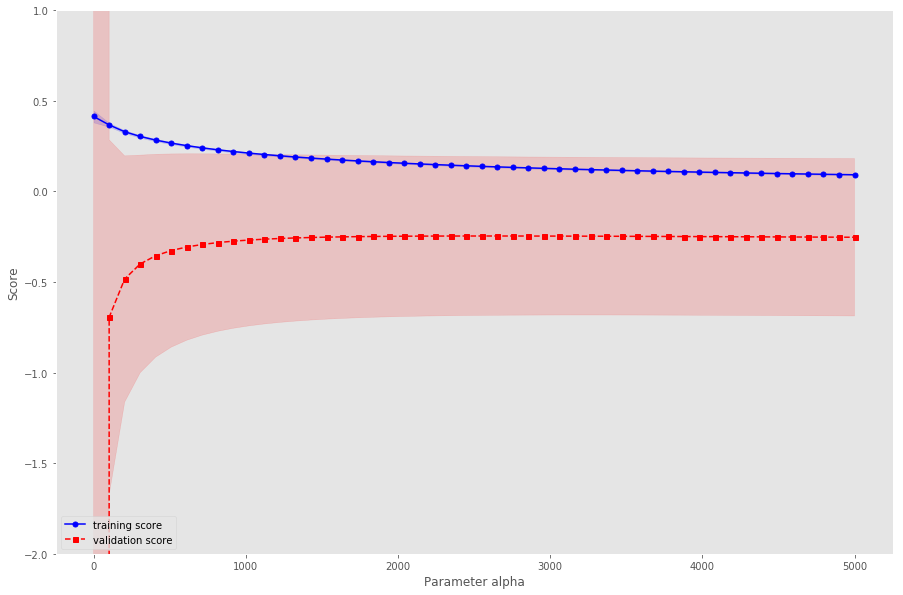

In [30]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training score');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation score');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
plt.legend(loc = 'lower left');
#plt.xscale('log');
plt.xlabel('Parameter alpha');
plt.ylabel('Score');
plt.ylim([-2, 1]);
#plt.xlim([0, 300]);

In [31]:
best_alpha = alpha_range[np.where(test_mean == max(test_mean))]
best_alpha

array([ 2551.02040816])

In [32]:
best_ridge = Ridge(alpha = best_alpha)
best_ridge.fit(X_train, y_train)

Ridge(alpha=array([ 2551.02041]), copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [33]:
preds = best_ridge.predict(X_valid)
rmse_ridge = np.sqrt(((preds - y_valid) ** 2).sum() / len(y_valid))
rmse_ridge

0.083040915366054055

In [34]:
pred_new = best_ridge.predict(X_new)
ridge_preds = pd.DataFrame(data=pred_new, columns=['preds'])
ridge_preds['stock'] = list(stocks)
ridge_preds = ridge_preds.sort_values('preds', ascending=False)
ridge_preds.head(len(stocks))

,preds,stock
9,1.062532,alk
2,1.049434,unp
3,1.049333,ilmn
10,1.043881,intu
8,1.040685,masi
5,1.033618,atvi
0,1.031294,newr
7,1.029714,cme
1,1.029149,nvda
6,1.027550,bb


# Neural Net

## Keras Model

In [35]:
best_val_loss = rmse_ridge
X_train.shape

(558, 135)

In [159]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 1 

# Current best
NODES_PER_LAYER = [n_inputs, 16, n_outputs]
ETA = 0.005
DROPOUT = 0.5
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 1000
BATCH_SIZE = 64

NODES_PER_LAYER

[135, 16, 1]

In [160]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [161]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
#model.add(BatchNormalization())
#model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 16)                2176      
_________________________________________________________________
batch_normalization_18 (Batc (None, 16)                64        
_________________________________________________________________
activation_18 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 17        
Total params: 2,257
Trainable params: 2,225
Non-trainable params: 32
_________________________________________________________________


In [162]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='mean_squared_error', optimizer=adam)

In [163]:
VERBOSE = 0
checkpointer = ModelCheckpoint(filepath='../data/weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=500)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start

In [164]:
print('Time: %.2f minutes' % (elapsed / 60))

Time: 0.84 minutes


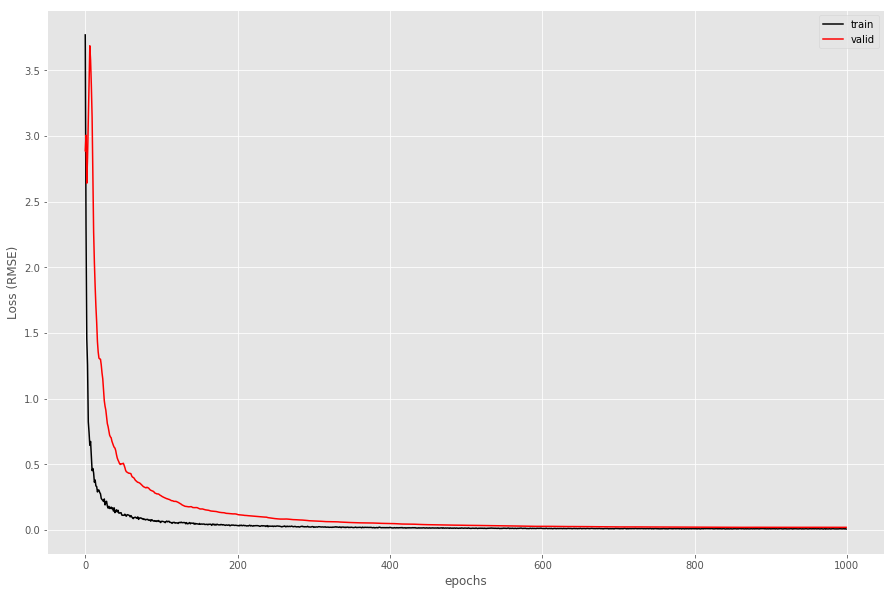

In [165]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (RMSE)')
#plt.yscale('log');
plt.legend(loc='best');
#plt.ylim([0, 0.1])

In [166]:
this_run = np.mean(history.history['val_loss'][-50:])
print('This run: %.7f' % this_run)

This run: 0.0200401


In [167]:
if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')
pprint(best_params)

Best validation loss so far: 0.00534
Training loss of same model: 0.01200
Best hyperparameters found so far:
{'BATCH_SIZE': 64,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0.5,
 'EPOCHS': 1000,
 'EPSILON': 1e-08,
 'ETA': 0.005,
 'NODES_PER_LAYER': [135, 8, 8, 8, 1]}


In [168]:
preds = model.predict(X_new)
preds = list(preds.reshape(len(X_new)))

In [169]:
df = pd.DataFrame(columns=['stocks'], data=list(stocks))
df['preds'] = preds
df = df.sort_values('preds', ascending=False)
df

,stocks,preds
9,alk,1.181999
10,intu,1.053941
6,bb,1.046336
0,newr,1.037080
3,ilmn,1.036356
8,masi,1.030086
4,nue,1.029480
7,cme,1.023052
2,unp,1.020063
1,nvda,1.012049


```
0.00534
8 	masi 	1.022999
10 	intu 	1.022999
5 	atvi 	1.022999
2 	unp 	1.022999
1 	nvda 	1.022999
0 	newr 	1.022999
6 	bb  	1.022999
4 	nue 	1.022999
7 	cme 	1.022999
3 	ilmn 	1.022977
                        12 	wtr 	1.022485
                        13 	awr 	1.022033
                        11 	cwt 	1.021583
                        14 	awk 	1.021299
9 	alk 	1.021089
                        15 	artna 	1.020254



0.00538
0 	newr 	1.024364
1 	nvda 	1.024364
3 	ilmn 	1.024364
13 	awr 	1.024364

12 	wtr 	1.024016
6 	bb  	1.023926
14 	awk 	1.023740
4 	nue 	1.023541
11 	cwt 	1.022290
15 	artna 	1.021814
9 	alk 	1.021672
7 	cme 	1.021583


0.00602
9 	alk 	1.067795
2 	unp 	1.032589
7 	cme 	1.031395
13 	awr 	1.029065
8 	masi 	1.028800
3 	ilmn 	1.025927
4 	nue 	1.025052
10 	intu 	1.023914
5 	atvi 	1.019476
6 	bb  	1.018610
15 	artna 	1.016547
11 	cwt 	1.014812
12 	wtr 	1.011542
1 	nvda 	1.011161
14 	awk 	1.011128
0 	newr 	1.007714



0.00731
0 	newr 	1.027734
4 	nue 	1.027734
6 	bb  	1.027734
7 	cme 	1.027734
9 	alk 	1.027734
10 	intu 	1.027734
8 	masi 	1.027583
5 	atvi 	1.027108
2 	unp 	1.027023
1 	nvda 	1.012424
3 	ilmn 	1.007744
11 	cwt 	1.007744
12 	wtr 	1.007744
13 	awr 	1.007744
14 	awk 	1.007744
15 	artna 	1.007744


0.0094571
9 	alk 	1.062685
3 	ilmn 	1.042506
8 	masi 	1.040163
0 	newr 	1.037365
13 	awr 	1.029387
10 	intu 	1.028862
6 	bb  	1.026617
2 	unp 	1.022523
5 	atvi 	1.012924
12 	wtr 	1.009851
15 	artna 	1.008452
1 	nvda 	1.005280
14 	awk 	1.005062
11 	cwt 	1.000561
7 	cme 	0.999885
4 	nue 	0.993363


0.0144473
3 	ilmn 	1.111817
10 	intu 	1.080894
6 	bb  	1.076914
2 	unp 	1.073780
0 	newr 	1.071209
8 	masi 	1.064939
4 	nue 	1.055335
1 	nvda 	1.051458
5 	atvi 	1.005735
7 	cme 	0.983148
9 	alk 	0.983148
11 	cwt 	0.983148
12 	wtr 	0.983148
13 	awr 	0.983148
14 	awk 	0.983148
15 	artna 	0.983148


0.0387078
2 	unp 	1.130290
4 	nue 	1.125606
6 	bb  	1.111176
10 	intu 	1.105672
3 	ilmn 	1.100313
7 	cme 	1.097335
8 	masi 	1.094330
1 	nvda 	1.087378
5 	atvi 	1.081015
0 	newr 	1.061893
12 	wtr 	1.009940
15 	artna 	1.009759
14 	awk 	0.991423
13 	awr 	0.975234
11 	cwt 	0.968198
9 	alk 	0.928422
```

## Tensorflow Model

In [37]:
#!mkdir stock_model_logs

In [38]:
def batch_norm(x, n_out, phase_train, layer_type):
    beta_init  = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta  = tf.get_variable('beta',  [n_out], initializer=beta_init)
    gamma = tf.get_variable('gamma', [n_out], initializer=gamma_init)
    axes = [0, 1, 2] if layer_type == 'conv' else [0]
    batch_mean, batch_var = tf.nn.moments(x, axes, name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    
    def  mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    mean, var = control_flow_ops.cond(
        phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    
    if layer_type != 'conv':
        x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(
        x, mean, var, beta, gamma, 1e-3, True)
    
    if layer_type != 'conv':
        normed = tf.reshape(normed, [-1, n_out])
    return normed

In [39]:
def layer_batch_norm(x, n_out, phase_train):
    return batch_norm(x, n_out, phase_train, 'fully_connected')

In [40]:
# Create a fully-connected layer
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(
        stddev=(2. / weight_shape[0]) ** 0.5)  # He
        #stddev=(2. / (weight_shape[0] + weight_shape[1])) ** 0.5) # Xavier
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable('W', weight_shape, initializer=weight_init)
    b = tf.get_variable('b', bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.relu(layer_batch_norm(  # <- or tanh
        logits, weight_shape[1], phase_train))

In [41]:
# Make with 2 fc layers, then update to generalize
def inference(x, keep_prob, phase_train, n_neurons):
    inputs = x
    for i in range(len(n_neurons) - 1):
        with tf.variable_scope('fc' + str(i + 1)):
            inputs = layer(inputs, 
                           [n_neurons[i], n_neurons[i + 1]],
                           n_neurons[i + 1],
                           phase_train)
            inputs = tf.nn.dropout(inputs, keep_prob)
    return inputs

In [42]:
def loss(output, y):
    #cost = tf.reduce_sum(tf.pow(output - y, 2)) # SSE
    cost = tf.sqrt(
        tf.reduce_mean(tf.square(tf.subtract(y, output)))) # RMSE
    return cost

In [43]:
def training(cost, global_step):
    #tf.summary.scalar('cost', cost)
    eta0 = ETA
    eta = tf.train.exponential_decay(
        eta0, global_step, DECAY_STEPS, DECAY_RATE, name='eta')
    optimizer = tf.train.AdamOptimizer(eta)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [44]:
ops.reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [45]:
#def training(cost, global_step):
#    #tf.summary.scalar('cost', cost)
#    optimizer = tf.train.AdamOptimizer(ETA)
#    train_op = optimizer.minimize(cost, global_step=global_step)
#    return train_op

In [46]:
# Run only before first model is executed
best_error_so_far = rmse_ridge

In [59]:
N, D = X_train.shape

# Hyperparmeters to tune
DROPOUT_RATE = 0.01
n_neurons = [D, D, D, 1]

# Programmed Learning with Decay
ETA = 0.5 # Learning rate
DECAY_STEPS = 100  # eta updates after this many epochs
DECAY_RATE = 0.99  # factor to change eta by

BATCH_SIZE = 64
EPOCHS = 3000

DISPLAY_STEP = 200

In [60]:
train_err = []
valid_err = []

with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        with tf.variable_scope('stock_mod'):
            # Init
            X = tf.placeholder(tf.float32, shape=[None, D], name='X')
            y = tf.placeholder(tf.float32, shape=None, name='y')
            keep_prob = tf.placeholder(tf.float32)
            phase_train = tf.placeholder(tf.bool) # T=train, F=Valid/Test
            output = inference(X, keep_prob, phase_train, n_neurons)
            cost = loss(output, y)
            global_step = tf.Variable(
                0, name='global_step', trainable=False)
            train_op = training(cost, global_step)
            saver = tf.train.Saver()
            sess = tf.Session()
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            tf.train.start_queue_runners(sess=sess)
            
            # Train
            for epoch in range(EPOCHS):
                avg_rmse = 0.
                idxs = np.random.permutation(range(N))
                n_batches = len(idxs) // BATCH_SIZE
                
                for batch in range(n_batches):
                    _, new_cost = sess.run(
                        [train_op, cost],
                        feed_dict={X: X_train[idxs, :],
                                   y: y_train[idxs],
                                   keep_prob: 1 - DROPOUT_RATE,
                                   phase_train: True})
                avg_rmse += new_cost / n_batches
                train_err.append(avg_rmse)

                validate_rmse = sess.run(
                    cost,
                    feed_dict={X: X_valid,
                               y: y_valid,
                               keep_prob: 1.,
                               phase_train: False})
                valid_err.append(validate_rmse)

                # Display output per display step
                if epoch % DISPLAY_STEP == 0:
                    print('Epoch: %04d Cost: %.8f\tValidation cost: %.8f' 
                          %(epoch + 1, avg_rmse, validate_rmse))

                    saver.save(sess, 
                               'stock_model_logs/model.ckpt', 
                               global_step=global_step)
            print('Optimization complete...')
            test_rmse = sess.run(cost, 
                                feed_dict={X: X_test,
                                           y: y_test,
                                           keep_prob: 1.,
                                           phase_train: False})
            print('Test RMSE: %.8f\n\n' %test_rmse)
            
            new_preds = sess.run(output, 
                                 feed_dict={X: X_new,
                                            keep_prob: 1., 
                                            phase_train: False})
            final_out = []
            for (stock, pred) in zip(
                    stocks, new_preds.reshape(new_preds.shape[0])):
                final_out.append([stock, pred])
    
            out = pd.DataFrame(columns=['Stock', 'Prediction'], 
                               data=final_out)
            out['LowerBound'] = out['Prediction'] - 2 * test_rmse
            out['UpperBound'] = out['Prediction'] + 2 * test_rmse
            out = out.sort_values('Prediction', ascending=False)
            print(out.head(len(stocks)))

Epoch: 0001 Cost: 0.12552226	Validation cost: 40.19169617
Epoch: 0201 Cost: 0.04293507	Validation cost: 0.15264906
Epoch: 0401 Cost: 0.03634217	Validation cost: 0.15333213
Epoch: 0601 Cost: 0.04472242	Validation cost: 0.15236823
Epoch: 0801 Cost: 0.04081369	Validation cost: 0.15890647
Epoch: 1001 Cost: 0.03319941	Validation cost: 0.14275464
Epoch: 1201 Cost: 0.03917455	Validation cost: 0.16633788
Epoch: 1401 Cost: 0.03917989	Validation cost: 0.16594633
Epoch: 1601 Cost: 0.03140240	Validation cost: 0.15696761
Epoch: 1801 Cost: 0.02975376	Validation cost: 0.16686974
Epoch: 2001 Cost: 0.03917575	Validation cost: 0.16799402
Epoch: 2201 Cost: 0.03319238	Validation cost: 0.16768393
Epoch: 2401 Cost: 0.03319230	Validation cost: 0.16801058
Epoch: 2601 Cost: 0.04234855	Validation cost: 0.17750300
Epoch: 2801 Cost: 0.04184610	Validation cost: 0.16771641
Optimization complete...
Test RMSE: 0.17153876


   Stock  Prediction  LowerBound  UpperBound
0   cboe    1.119308    0.776231    1.462386
9    

In [55]:
#print(np.mean(y_train))
print(np.std(y_train))

0.0850766207489


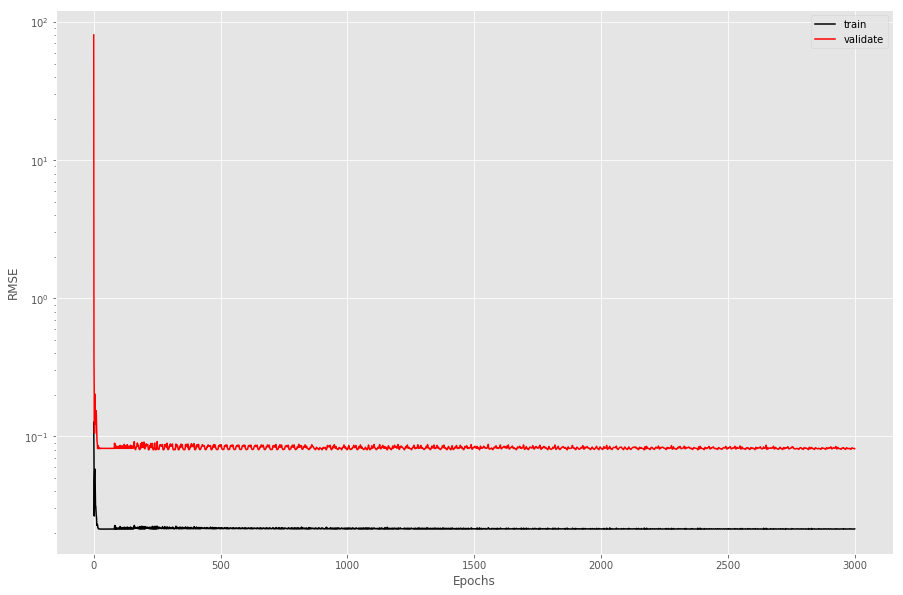

In [56]:
plt.plot(train_err, 'k-', label='train');
plt.plot(valid_err, 'r-', label='validate');
plt.legend(loc='best');
plt.xlabel('Epochs');
plt.ylabel('RMSE');
plt.yscale('log')
#plt.xscale('log')

In [57]:
appx_validation_error = np.mean(valid_err[-100:])
appx_train_error      = np.mean(train_err[-100:])
print('Previous Best:', best_error_so_far)
print('This run:     ', appx_validation_error, 'Train: ', appx_train_error)

Previous Best: 0.0837089368526
This run:      0.081827 Train:  0.0213069126196


In [58]:
if appx_validation_error < best_error_so_far:
    best_error_so_far = appx_validation_error
    print('New Best Model Found!\nHyperparameters:\n' + ('-' * 70))
    hyperparams = {
        'best_error_so_far': appx_validation_error,
        'best_dropout': DROPOUT_RATE,
        'best_architecture': n_neurons,
        'best_eta': ETA,
        'best_decay_steps': DECAY_STEPS,
        'best_decay_rate': DECAY_RATE,
        'epochs': EPOCHS}
for k, v in hyperparams.items():
    print('%17s: %s' %(k, str(v)))

New Best Model Found!
Hyperparameters:
----------------------------------------------------------------------
best_error_so_far: 0.081827
     best_dropout: 0.0
best_architecture: [128, 128, 128, 1]
         best_eta: 0.5
 best_decay_steps: 100
  best_decay_rate: 0.99
           epochs: 3000


```
   Stock  Prediction  LowerBound  UpperBound
11   mkc    1.015311    0.854142    1.176480
9    txt    1.015256    0.854087    1.176425
0   cboe    1.015224    0.854055    1.176393
10   kmi    1.015203    0.854034    1.176372
14  ndaq    1.015198    0.854028    1.176367
3   odfl    1.015192    0.854023    1.176362
5   atvi    1.015190    0.854021    1.176359
2   intu    1.015177    0.854008    1.176346
1    hca    1.015171    0.854002    1.176340
16  sbux    1.015143    0.853974    1.176312
6   masi    1.015141    0.853972    1.176310
12  mtch    1.015140    0.853971    1.176310
15   nyt    1.015121    0.853952    1.176290
13   mtn    1.015076    0.853907    1.176245
4   aapl    1.015076    0.853907    1.176245
8   stmp    1.015065    0.853896    1.176234
7   pypl    1.015043    0.853874    1.176212
```